## Audio diffusion using latent DDIM diffusion

This works by taking samples from the latent space of the model using a different seed. 

We can then interpolate between samples, however randomly sampling from latent space makes it difficult to find audio that sounds good. 

Perhapse experiment with clustering or finding clusters? 

Also chaging the seed could be an interesting control

In [ ]:
import torch
import matplotlib.pyplot as plt
import random
import threading
from librosa.beat import beat_track
from pythonosc import dispatcher, osc_server
import numpy as np
from datasets import load_dataset
from diffusers_local import DiffusionPipeline, DDIMScheduler, AudioDiffusionPipeline, AutoencoderKL, Mel, UNet2DModel
import soundfile as sf
from CreateDataset import AudioProcessor
from NetworkBending import NetworkBending
from HifiVocoder import HifiVocoder
import time

osc_lock = threading.Lock()

NB = NetworkBending()

device = "cuda" if torch.cuda.is_available() else "cpu"

vocoder = HifiVocoder(checkpoint_file='hifigan\hifi256\g_00320000')

# apply the custom unet model so we can Networkbend the audio
unet = UNet2DModel.from_pretrained("teticio/latent-audio-diffusion-ddim-256", subfolder="unet")
#set the scheduler to DDIM
scheduler = DDIMScheduler.from_pretrained("teticio/latent-audio-diffusion-ddim-256", subfolder="scheduler")
#set the vqvae
vqvae = AutoencoderKL.from_pretrained("teticio/latent-audio-diffusion-ddim-256", subfolder="vqvae")

mel = Mel()

audio_diffusion = AudioDiffusionPipeline(
    vqvae=vqvae, 
    unet=unet,
    mel=mel,
    vocoder=vocoder,
    scheduler=scheduler,
)

#load the model to the GPU/CPU
audio_diffusion.to(device)

#define the vae so we can access the latent space
vae = audio_diffusion.vqvae

print(audio_diffusion)

x = 0
y = 0
coord = np.array([x, y])
alpha = 0
latent1 = 0
latent2 = 1
diffusion_steps = 10
make_loop = 0
generate = 1


In [ ]:
# import numpy as np
# from PIL import Image

# # Load the spectrogram image
# image_path = 'generated_image.png'
# image = Image.open(image_path).convert("L")  # Convert to grayscale if needed

# # Convert the image to a NumPy array
# spectrogram_array = np.array(image)

# # Calculate mean and std for each frequency bin (axis=1 is time)
# mean = np.mean(spectrogram_array, axis=1)  # Shape (512,)
# std = np.std(spectrogram_array, axis=1)    # Shape (512,)

# # Save these values for normalization in MelGAN
# np.save("data/drumbeats_1bar/mean_512.mel.npy", mean)
# np.save("data/drumbeats_1bar/std_512.mel.npy", std)

# print("Normalization files saved with shape:", mean.shape)



In [ ]:
# Load audio and process it into 5 second spectrograms
input_dir = r"C:\\Users\\danhearn\\Music"
processor = AudioProcessor(input_dir)
processor.process_directory()

In [ ]:
# #encode images in latent space
# decoded_images = []

# for i in range(10):
#     generator = torch.Generator(device="cuda").manual_seed(random.randint(0, 1000))
#     decoded_images.append(
#         torch.randn(
#             (1, audio_diffusion.unet.in_channels, audio_diffusion.unet.sample_size[0], audio_diffusion.unet.sample_size[1]),
#             generator=generator,
#             device="cuda")
#     )


In [33]:
import torch
from torchvision import transforms
from PIL import Image
import os

# Define preprocessing transformations (adjust based on your model's requirements)
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),  # Reshape to the VAE's input size
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize([0.5], [0.5])  # Normalization, adjust if necessary
])

# Load and preprocess spectrogram images
def load_and_preprocess_image(path):
    image = Image.open(path).convert("L")
    return preprocess(image)

# Assuming you have a list of paths to your spectrogram images
# Directory containing spectrogram images
spectrogram_dir = "data/mel_spectrograms"

# Get a list of spectrogram image paths
spectrogram_paths = [os.path.join(spectrogram_dir, fname) for fname in os.listdir(spectrogram_dir) if fname.endswith(".png")]

# Select the first 50 spectrograms
spectrogram_paths = spectrogram_paths[:30]

# Load and preprocess the spectrogram images
spectrograms = torch.stack([load_and_preprocess_image(p) for p in spectrogram_paths])

# Send spectrograms to the appropriate device
spectrograms = spectrograms.to(device)
spectrograms


tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -0.0667, -0.0275,  0.1137],
          [-1.0000, -1.0000, -1.0000,  ..., -0.1373,  0.1294,  0.2941],
          [-1.0000, -1.0000, -1.0000,  ...,  0.5451,  0.5294,  0.4039],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.5765],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.6863],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.7176]]],


        [[[ 0.4510,  0.2706, -0.0431,  ..., -0.0275,  0.1529,  0.2392],
          [ 0.6000,  0.5059,  0.2549,  ...,  0.3412,  0.2706,  0.4980],
          [ 0.7333,  0.7882,  0.6941,  ...,  0.6941,  0.6784,  0.6941],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.9686],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8902],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8980]]],


        [[[ 0.5294,  0.3882,  0.1373,  ..., -0.2627, -0.0431,  0.3882],
          [ 0.6235,  0.505

In [ ]:
with torch.no_grad():
    latent_vectors = vae.encode(spectrograms).latent_dist.mean  # Mean of the distribution

In [ ]:
# Assuming vae and preprocess are defined as before
latent_vectors = []

for path in spectrogram_paths:
    # Preprocess the image
    spectrogram = load_and_preprocess_image(path).unsqueeze(0).to(device)  # Add batch dimension
    
    # Encode to latent vector
    with torch.no_grad():
        latent_vector = vae.encode(spectrogram).latent_dist.mean  # Get the mean of the latent distribution
    
    # Flatten latent vector and add to list
    latent_vectors.append(latent_vector.view(-1))  # Flatten to 1D

# Stack latent vectors to form a 2D tensor suitable for clustering
latent_vectors = torch.stack(latent_vectors)


In [ ]:
from sklearn.cluster import KMeans

# Specify the number of clusters
n_clusters = 30
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Fit the clustering model to the latent vectors
cluster_labels = kmeans.fit_predict(latent_vectors.cpu().numpy())


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensions for visualization
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_vectors.cpu().numpy())

# Plot clusters
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=cluster_labels, cmap='viridis')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Clusters of Spectrograms in Latent Space")
plt.colorbar()

# Save the plot as an image file
plt.savefig("latent_space_clusters.png")

# Show plot if possible
plt.show()


In [ ]:
# Get the min and max values for each PCA component
x_min, x_max = latent_2d[:, 0].min(), latent_2d[:, 0].max()
y_min, y_max = latent_2d[:, 1].min(), latent_2d[:, 1].max()

print(f"X range: {x_min} to {x_max}")
print(f"Y range: {y_min} to {y_max}")


In [ ]:
from sklearn.metrics import pairwise_distances

# Calculate cluster centroids in latent_2d
cluster_centers = []
for label in np.unique(cluster_labels):
    cluster_points = latent_2d[cluster_labels == label]
    centroid = cluster_points.mean(axis=0)
    cluster_centers.append(centroid)

# Calculate average distance of points to their respective cluster centroid
cluster_radii = []
for label, center in zip(np.unique(cluster_labels), cluster_centers):
    cluster_points = latent_2d[cluster_labels == label]
    distances = np.linalg.norm(cluster_points - center, axis=1)
    cluster_radii.append(distances.mean())

# Print cluster radii to understand approximate boundaries
for i, radius in enumerate(cluster_radii):
    print(f"Cluster {i} radius: {radius}")


Latent cluster interpolation 

In [ ]:
# Choose a latent vector from Cluster 1
cluster_1_indices = [i for i, label in enumerate(cluster_labels) if label == 0]  # Adjust to select the desired cluster
latent1 = latent_vectors[cluster_1_indices[0]]  # Use the first vector in Cluster 1
# Ensure the latent vector matches the unet input requirements
latent1 = latent1.view(1, audio_diffusion.unet.config.in_channels, audio_diffusion.unet.sample_size[0], audio_diffusion.unet.sample_size[1])

In [38]:
# Choose a latent vector from Cluster 1
cluster_2_indices = [i for i, label in enumerate(cluster_labels) if label == 9]  # Adjust to select the desired cluster
latent2 = latent_vectors[cluster_2_indices[0]]  
# Ensure the latent vector matches the unet input requirements
latent2 = latent2.view(1, audio_diffusion.unet.config.in_channels, audio_diffusion.unet.sample_size[0], audio_diffusion.unet.sample_size[1])

100%|██████████| 10/10 [00:00<00:00, 29.77it/s]

Sample shape adjusted to torch.Size([1, 256, 256])


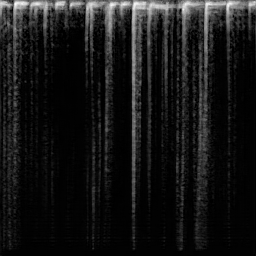

In [39]:
from IPython.display import display, Audio

generator = torch.Generator(device="cuda").manual_seed(42)

alpha = 0  #@param {type:"slider", min:0, max:1, step:0.1}


output = audio_diffusion(steps=10,
    noise=AudioDiffusionPipeline.slerp(latent1, latent2, alpha),
    generator=generator)
display(output.images[0])
display(Audio(output.audios[0], rate=22050))

END LATENT CLUSTER INTERPOLATION 

--- START CLUSTERSPACE INTERPOLATION --- 


In [ ]:
import numpy as np
import torch

def navigate_latent_space(latent_2d, latent_vectors, coord, k=3):
    """
    Interpolates in the latent space of the model based on the nearest encoded spectrograms.

    Parameters:
    - latent_2d: 2D PCA-reduced latent space (numpy array [num_samples, 2]).
    - latent_vectors: Original latent vectors (PyTorch tensor [num_samples, latent_dim] on device).
    - coord: The 2D coordinate in PCA space from the slider (numpy array [2,]).
    - k: Number of nearest spectrograms to use for interpolation.

    Returns:
    - Interpolated latent vector as a PyTorch tensor based on weighted contribution of nearest spectrograms.
    """
    # Calculate distances from `coord` to each spectrogram in the 2D latent space
    distances = np.linalg.norm(latent_2d - coord, axis=1)
    
    # Find the indices of the k nearest spectrograms
    nearest_indices = np.argsort(distances)[:k]
    
    # Retrieve the corresponding latent vectors from `latent_vectors`
    nearest_latents = latent_vectors[nearest_indices]

    # Calculate weights inversely proportional to distances
    nearest_distances = distances[nearest_indices]
    weights = 1 / (nearest_distances + 1e-8)  # Add epsilon to avoid division by zero
    weights /= weights.sum()  # Normalize weights to sum to 1

    # Weighted average of the nearest latent vectors
    interpolated_latent = torch.sum(nearest_latents * torch.tensor(weights, device=latent_vectors.device).view(-1, 1), dim=0)
    
    return interpolated_latent



In [ ]:
from IPython.display import display, Audio
generator = torch.Generator(device="cpu").manual_seed(42)

x = 65756756
y = 567567567
coord = np.array([x, y])  # Coordinates from the slider in PCA space
interpolated_latent = navigate_latent_space(latent_2d, latent_vectors, coord, k=3)

# Reshape the interpolated latent for your model’s input
noise = torch.tensor(interpolated_latent, dtype=torch.float32, device=device).view(
    1, audio_diffusion.unet.config.in_channels,
    audio_diffusion.unet.sample_size[0],
    audio_diffusion.unet.sample_size[1],
)


output = audio_diffusion(steps=40,
    noise=noise,
    generator=generator)
display(output.images[0])
display(Audio(output.audios[0], rate=22050))

In [ ]:
def loop_it(audio: np.ndarray,
        sample_rate: int,
        loops: int = 1) -> np.ndarray:
    """Loop audio

    Args:
        audio (np.ndarray): audio as numpy array
        sample_rate (int): sample rate of audio
        loops (int): number of times to loop

    Returns:
        (float, np.ndarray): sample rate and raw audio or None
    """
    _, beats = beat_track(y=audio, sr=sample_rate, units='samples')
    for beats_in_bar in [16, 12, 8, 4]:
        if len(beats) > beats_in_bar:
            return np.tile(audio[beats[0]:beats[beats_in_bar]], loops)
    return None

def interpolation(address, *args):
    
    """Interpolate between two latents for generation
    Args:
        address (str): OSC address
        *args: OSC arguments
    """

    global alpha, latent1, latent2
    
    if address == "/alpha":
        alpha = args[0]
    if address == "/latent1" and latent2 != args[0]:
        latent1 = int(args[0])
    if address == "/latent2" and latent1 != args[0]:
        latent2 = int(args[0])

def inference(address, *args):

    """Control the inference process
    Args:
        address (str): OSC address
        *args: OSC arguments
    """

    global diffusion_steps, make_loop, generate

    if address == "/steps":
        diffusion_steps = int(args[0])
    if address == "/loop":
        make_loop = int(args[0])
    if address == "/generate":
        generate = int(args[0])

def coords(address, *args):


    """Control the 2D coordinates for interpolation
    Args:
        address (str): OSC address
        *args: OSC arguments
    """

    global x, y

    if address == "/x":
        x = args[0]
        print(x)
    if address == "/y":
        y = args[0]
        print(y)

In [ ]:
#osc listener
from pythonosc import dispatcher, osc_server

ip="127.0.0.1"
port=9999

d = dispatcher.Dispatcher()
# Map incoming OSC messages to the osc_receive method
d.map("/rotate_x_radian",  NB.osc_receive)
d.map("/rotate_y_radian", NB.osc_receive)
d.map("/rotate_z_radian", NB.osc_receive)
d.map("/rotate_x_scaling_factor", NB.osc_receive)
d.map("/rotate_y_scaling_factor", NB.osc_receive)
d.map("/rotate_z_scaling_factor", NB.osc_receive)
d.map("/scale_factor", NB.osc_receive)
d.map("/layer", NB.osc_receive)
d.map("/scale", NB.osc_receive)
d.map("/reflect", NB.osc_receive)
d.map("/erosion", NB.osc_receive)
d.map("/dilation", NB.osc_receive)
d.map("/gradient", NB.osc_receive)
d.map("/sobel", NB.osc_receive)
d.map("/add_rand_rows", NB.osc_receive)
d.map("/normalize", NB.osc_receive)
d.map("/rotate_x", NB.osc_receive)
d.map("/rotate_y", NB.osc_receive)
d.map("/rotate_z", NB.osc_receive)
d.map("/alpha", interpolation)
d.map("/latent1", interpolation)
d.map("/latent2", interpolation)
d.map("/steps", inference)
d.map("/loop", inference)
d.map("/generate", inference)
d.map("/x", coords)
d.map("/y", coords)

s = osc_server.ThreadingOSCUDPServer((ip, port), d)

osc_thread = threading.Thread(target=s.serve_forever)
osc_thread.daemon = True # This will allow the main program to exit even if the OSC server is still running
osc_thread.start()
print("OSC server started - listening on port 9999")

In [ ]:
# Main loop for image generation
try:
    while True:
        with osc_lock: 

            if generate == 1:
                interpolated_latent = weighted_cluster_interpolation(latent_2d, latent_vectors, coord, cluster_labels, cluster_centers)
                noise = torch.tensor(interpolated_latent, dtype=torch.float32, device=device).view(
                1, audio_diffusion.unet.config.in_channels,
                audio_diffusion.unet.sample_size[0],
                audio_diffusion.unet.sample_size[1],
                )                
                output = audio_diffusion(steps=diffusion_steps,noise=noise,generator=generator)               

                output.images[0].save("generated_image.png")
                audio = output.audios[0, 0]

                if make_loop == 1:
                    loop = loop_it(audio, audio_diffusion.mel.get_sample_rate())
                    sf.write("output_audio.wav", loop, audio_diffusion.mel.get_sample_rate())
                elif make_loop == 0:
                    #time.sleep(0.05)
                    sf.write("output_audio.wav", audio, audio_diffusion.mel.get_sample_rate())



except KeyboardInterrupt:
    s.shutdown()
    print("Terminating the loop gracefully.")